STAGE 1 DATA PREPROCESSING

In [1]:
#GET THE DATA FIRST

In [70]:
import tensorflow as tf
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import os
from IPython.display import display, Audio
from sklearn.model_selection import train_test_split

In [71]:
with open('../util/tokenizer.txt','r') as infile:
    data = json.load(infile)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
VOCAB_SIZE = len(tokenizer.word_index)
TEXT_PADDING = 8
WINDOW_SIZE = 1000 #in ms
SLIDE_STRIDE = 300 # in ms

EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

In [72]:
#EXTRACT INPUTS AND TARGETS

In [73]:
X_mfccs = np.load('../util/X_mfccs_error_4000.npy')
X_transcripts = np.load('../util/X_transcripts_error_4000.npy')
clips = np.load('../util/X_clips_error_4000.npy')
Y = np.load('../util/labels_error_4000.npy')
print(X_mfccs.shape)

(45135, 63, 16)


In [74]:
#LOAD TRAIN AND TEST SPLITS

In [75]:
X_train_mfcc, X_test_mfcc, X_train_transcript, X_test_transcript, clips_train, clips_test, y_train, y_test = train_test_split(X_mfccs,X_transcripts,clips,Y,test_size=0.1)
print(X_train_mfcc.shape)
print(X_train_transcript.shape)
print(clips_train.shape)
print(y_train.shape)

(40621, 63, 16)
(40621, 32)
(40621,)
(40621,)


In [76]:
mu = np.mean(X_train_mfcc,axis=0)
std_dev = np.std(X_train_mfcc,axis=0)
X_train_mfcc -= mu
X_test_mfcc -= mu
X_train_mfcc /= std_dev
X_test_mfcc /= std_dev
print(X_train_mfcc.shape)

(40621, 63, 16)


In [77]:
X_train_mfcc = X_train_mfcc[...,np.newaxis]
X_test_mfcc = X_test_mfcc[...,np.newaxis]

In [78]:
X_train_mfcc[0].shape
X_train_mfcc.shape

(40621, 63, 16, 1)

STAGE 2 BUILDING AND COMPILING THE MODEL

In [79]:
#BUILD THE MODEL

In [80]:
# model_mfcc = tf.keras.Sequential()

#conv layer 1
mfcc_input = tf.keras.layers.Input(shape=X_train_mfcc[0].shape, name='mfcc_input')
conv1 = tf.keras.layers.Conv2D(128,(3,3),
                                 activation='relu',
                                 input_shape=X_train_mfcc[0].shape,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(mfcc_input)
norm1 = tf.keras.layers.BatchNormalization()(conv1)
pool1 = tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same')(norm1)

#conv layer 2
conv2 = tf.keras.layers.Conv2D(64,(3,3),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool1)
norm2 = tf.keras.layers.BatchNormalization()(conv2)
pool2 = tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same')(norm2)


#conv layer 3
conv3 = tf.keras.layers.Conv2D(32,(2,2),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool2)
norm3 = tf.keras.layers.BatchNormalization()(conv3)
pool3 = tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same')(norm3)



# #flatten output
flat = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(64,activation = 'relu')(flat)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)

dense2 = tf.keras.layers.Dense(64,activation = 'relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)



In [81]:
# model_trans = tf.keras.Sequential()
trans_input = tf.keras.layers.Input(shape=X_train_transcript[0].shape, name='trans_input')
emb = tf.keras.layers.Embedding(VOCAB_SIZE, 128, input_length=TEXT_PADDING)(trans_input)

#LMST Layer 1
lstm1 = tf.keras.layers.LSTM(128,activation='relu',return_sequences = True)(emb)
lstm_drop_1 = tf.keras.layers.Dropout(0.25)(lstm1)

#LMST Layer 2
lstm2 = tf.keras.layers.LSTM(128,activation='relu')(lstm_drop_1)
lstm_drop_2 = tf.keras.layers.Dropout(0.25)(lstm2)

#Dense 
lstm_dense_1 = tf.keras.layers.Dense(64,activation='relu')(lstm_drop_2)
lstm_drop_3 = tf.keras.layers.Dropout(0.25)(lstm_dense_1)

#Dense 
lstm_dense_2 = tf.keras.layers.Dense(64,activation='relu')(lstm_drop_3)
lstm_drop_4 = tf.keras.layers.Dropout(0.25)(lstm_dense_2)

In [82]:
#output layer
concat = tf.keras.layers.concatenate([drop2,lstm_drop_4])
output = tf.keras.layers.Dense(1,activation='sigmoid')(concat)
# print(concat.shape)
# model.add()
# model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model = tf.keras.Model(inputs=[mfcc_input,trans_input],outputs=output)

In [83]:
#COMPILE

In [84]:
op = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=op, metrics=['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc_input (InputLayer)         [(None, 63, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 61, 14, 128)  1280        mfcc_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 61, 14, 128)  512         conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 31, 7, 128)   0           batch_normalization_6[0][0]      
_______________________________________________________________________________________

In [85]:
#FIT

In [86]:
result = model.fit([X_train_mfcc,X_train_transcript],y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,validation_split = 0.2)

Epoch 1/3
508/508 [==============================] - 145s 286ms/step - loss: 0.6165 - accuracy: 0.7673 - val_loss: 0.5669 - val_accuracy: 0.8206
Epoch 2/3
508/508 [==============================] - 138s 272ms/step - loss: 0.5277 - accuracy: 0.8181 - val_loss: 0.5092 - val_accuracy: 0.8311
Epoch 3/3
508/508 [==============================] - 165s 324ms/step - loss: 0.4993 - accuracy: 0.8304 - val_loss: 0.4988 - val_accuracy: 0.8299


In [87]:
history = result.history
tr_acc = history['accuracy']
val_acc = history['val_accuracy']
epochs = range(1, len(tr_acc)+1)

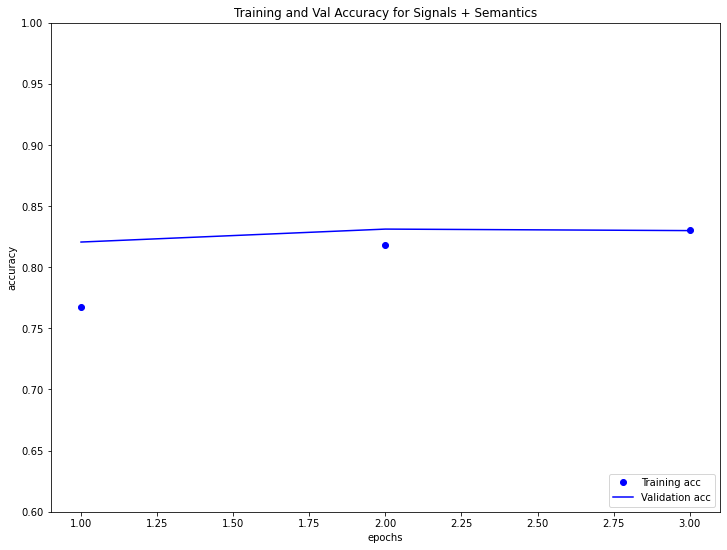

In [88]:
plt.figure(figsize=(12,9))
plt.plot(epochs,tr_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Val Accuracy for Signals + Semantics')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim((0.6,1))
plt.show()

In [89]:
#INFERENCE:
X_test_mfcc

array([[[[ 0.71310794],
         [-0.77434057],
         [ 0.229462  ],
         ...,
         [-0.46517637],
         [ 1.2151351 ],
         [-0.47422728]],

        [[ 0.5550589 ],
         [-0.90438026],
         [ 0.21129586],
         ...,
         [-0.4481818 ],
         [ 0.9814011 ],
         [-0.4521653 ]],

        [[ 0.10479663],
         [-0.98945165],
         [-0.0898999 ],
         ...,
         [-0.56005114],
         [ 0.21635637],
         [ 0.41459686]],

        ...,

        [[ 1.1458439 ],
         [ 0.22734675],
         [-1.3844944 ],
         ...,
         [-0.6032381 ],
         [ 0.346966  ],
         [ 0.49960276]],

        [[ 0.88364387],
         [-0.17601557],
         [ 0.5916554 ],
         ...,
         [-0.7106106 ],
         [ 0.941506  ],
         [ 1.2442404 ]],

        [[ 0.68575644],
         [-0.04840488],
         [ 1.1846281 ],
         ...,
         [-0.03981621],
         [ 0.34898087],
         [ 0.8707433 ]]],


       [[[ 0.8559511 ],


In [90]:
results = model.evaluate([X_test_mfcc,X_test_transcript],y_test)

142/142 [==============================] - 5s 36ms/step - loss: 0.4970 - accuracy: 0.8358


In [91]:
#ERROR ANALYSIS:

In [92]:
predictions = model.predict([X_test_mfcc,X_test_transcript])
valid_indexes = []
invalid_indexes=[]
for i in range(len(y_test)):
    if(y_test[i] == 0):
        invalid_indexes.append(i)
    else:
        valid_indexes.append(i)

In [93]:
def get_pred(val):
    return np.around(val)
print("PERFORMANCE ON POSITIVE EXAMPLES:")
total_pos = len(valid_indexes)
total_right_pops = 0
false_neg_clips = []
for i in valid_indexes:
    if(get_pred(predictions[i]) == get_pred(y_test[i])):
        total_right_pops += 1
    else:
        print(clips_test[i])
        false_neg_clips.append(clips_test[i])
        print("Prediction: ",get_pred(predictions[i]),". Label: ", get_pred(y_test[i]))
    
print("TOTAL POSITIVE EXMPLES: ", total_pos)
print("TOTAL CORRECT POSITIVE:", total_right_pops)
print("POSITIVE EXAMPLES ACC: ", total_right_pops/total_pos)

PERFORMANCE ON POSITIVE EXAMPLES:
../data/21/audio/8ba130f11e7445f0/mixed.wav_35_5121
Prediction:  [0.] . Label:  1
../data/49/audio/0c7502bec9984860/mixed.wav_34_9038
Prediction:  [0.] . Label:  1
../data/48/audio/8232c0939c4b45e4/mixed.wav_28_17411
Prediction:  [0.] . Label:  1
../data/36/audio/bee3cc0fa4bd4045/mixed.wav_55_13300
Prediction:  [0.] . Label:  1
../data/85/audio/41881646b40240e7/mixed.wav_27_14200
Prediction:  [0.] . Label:  1
../data/42/audio/6c7f7e01ab0f4927/mixed.wav_1_7600
Prediction:  [0.] . Label:  1
../data/36/audio/0de8df3d75354436/mixed.wav_8_9400
Prediction:  [0.] . Label:  1
../data/68/audio/fe1a98b6c3ff414c/mixed.wav_4_4649
Prediction:  [0.] . Label:  1
../data/68/audio/04dde71bf2a34d21/mixed.wav_43_6865
Prediction:  [0.] . Label:  1
../data/36/audio/45c6acbf6e784f5a/mixed.wav_60_8931
Prediction:  [0.] . Label:  1
../data/50/audio/eb47bf09c3744f09/mixed.wav_31_6100
Prediction:  [0.] . Label:  1
../data/63/audio/234a05c9566e412e/mixed.wav_19_9933
Prediction: 

In [94]:
print("PERFORMANCE ON NEGATIVE EXAMPLES:")
total_neg = len(invalid_indexes)
total_right_neg = 0
false_pos_clips = []
for i in invalid_indexes:
    if(get_pred(predictions[i]) == get_pred(y_test[i])):
        total_right_neg += 1
    else:
        print(clips_test[i])
        false_pos_clips.append(clips_test[i])
        print("Prediction: ", get_pred(predictions[i]),". Label: ",get_pred(y_test[i]))
print("TOTAL NEGATIVE EXMPLES: ", total_neg)
print("TOTAL CORRECT NEGATIVE:", total_right_neg)
print("NEGATIVE EXAMPLES ACC: ", total_right_neg/total_neg)

PERFORMANCE ON NEGATIVE EXAMPLES:
../data/56/audio/e9eeaa54a0704702/mixed.wav_15_10300
Prediction:  [1.] . Label:  0
../data/40/audio/2f7ceea5edee441f/mixed.wav_78_6700
Prediction:  [1.] . Label:  0
../data/63/audio/3d0d4ea0a672494c/mixed.wav_5_11500
Prediction:  [1.] . Label:  0
../data/49/audio/59830ecd46ec46e0/mixed.wav_6_5200
Prediction:  [1.] . Label:  0
../data/8/audio/a0ac9427e6a249bf/mixed.wav_44_6400
Prediction:  [1.] . Label:  0
../data/37/audio/1c13049f814642fc/mixed.wav_34_9400
Prediction:  [1.] . Label:  0
../data/17/audio/d86f9dc9396a4147/mixed.wav_31_5800
Prediction:  [1.] . Label:  0
../data/46/audio/a85b2dcbc78b4a23/mixed.wav_16_6700
Prediction:  [1.] . Label:  0
../data/58/audio/52bd772803c14691/mixed.wav_24_10000
Prediction:  [1.] . Label:  0
../data/77/audio/33ea98c31d364286/mixed.wav_4_8200
Prediction:  [1.] . Label:  0
../data/42/audio/8983eed176d14e39/mixed.wav_7_7900
Prediction:  [1.] . Label:  0
../data/85/audio/039bd552e75648ae/mixed.wav_15_5200
Prediction:  [

Prediction:  [1.] . Label:  0
../data/56/audio/e8ed9360645c4d1d/mixed.wav_35_7600
Prediction:  [1.] . Label:  0
../data/8/audio/99d3d48cea644bff/mixed.wav_3_5500
Prediction:  [1.] . Label:  0
../data/46/audio/45432a33f0c24ea1/mixed.wav_9_5500
Prediction:  [1.] . Label:  0
../data/21/audio/95896d5722df4af8/mixed.wav_67_16600
Prediction:  [1.] . Label:  0
../data/8/audio/83199b51c4bb45cc/mixed.wav_45_7600
Prediction:  [1.] . Label:  0
../data/53/audio/51d0d7f634de497f/mixed.wav_16_7900
Prediction:  [1.] . Label:  0
../data/31/audio/ec0ac60f80ee48c1/mixed.wav_52_7530
Prediction:  [1.] . Label:  0
../data/37/audio/8096ebc4e4c9431e/mixed.wav_7_5200
Prediction:  [1.] . Label:  0
../data/21/audio/56ab6ac1db534c1f/mixed.wav_38_5800
Prediction:  [1.] . Label:  0
../data/63/audio/c8d2370c4bdb44ad/mixed.wav_3_7000
Prediction:  [1.] . Label:  0
../data/50/audio/ae500e5dc0484d6a/mixed.wav_32_7600
Prediction:  [1.] . Label:  0
../data/63/audio/fd35fd2a61bd4112/mixed.wav_5_7000
Prediction:  [1.] . La

In [95]:
print("TOTAL EXMPLES: ", total_neg + total_pos)
print("TOTAL CORRECT :", total_right_neg + total_right_pops)
print("ACC: ", (total_right_neg + total_right_pops)/(total_neg + total_pos))

TOTAL EXMPLES:  4514
TOTAL CORRECT : 3773
ACC:  0.8358440407620735


In [96]:
false_pos_clips = np.array(false_pos_clips)
false_neg_clips = np.array(false_neg_clips)
np.save('../util/false_positives_4000.npy',false_pos_clips)
np.save('../util/false_negatives_4000.npy',false_neg_clips)

In [ ]:
#OLD MODEL

In [ ]:
model = tf.keras.Sequential()

#conv layer 1
model.add(tf.keras.layers.Conv2D(64,(3,3),
                                 activation='relu',
                                 input_shape=X_train[0].shape,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))

#conv layer 2
model.add(tf.keras.layers.Conv2D(32,(3,3),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))

#conv layer 3
model.add(tf.keras.layers.Conv2D(32,(2,2),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))

#flatten output
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))

#flatten output
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))

#output layer
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
op = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='binary_crossentropy',optimizer=op, metrics=['accuracy'])
model.summary()

TRAIN MODEL

In [ ]:
model.fit(X_train,y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,validation_split = 0.2)